In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from LegoRL import *

In [3]:
import gym
def make_env():
    def _thunk():
        env = gym.make('CartPole-v0').unwrapped
        return env
    return _thunk

In [4]:
import torch.nn as nn
CartpoleNN = lambda: nn.Sequential(
                nn.Linear(4, 20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.ReLU()
)

# ActorCritic

In [5]:
agent = Composed(
    visualizer   = Visualizer(),
    runner       = Runner(policy="policy", threads=8),
    rollout      = RolloutCollector(runner="runner", rollout_length=5),
    backbone     = Backbone(CartpoleNN()),
    policy       = PolicyHead(backbone="backbone"),
    critic       = ValueHead(backbone="backbone"),
    actor_loss   = ActorLoss(rollout="rollout", policy="policy", advantage_provider="critic_loss"),
    critic_loss  = OnlineCriticLoss(rollout="rollout", critic="critic"),
    entropy_loss = EntropyLoss(rollout="rollout", policy="policy"),
    trainer      = Trainer(backbone="backbone", losses=["actor_loss", "critic_loss", "entropy_loss"], weights=[1, 0.5, 0.01])
)

In [6]:
system = System(agent, make_env=make_env)

Adding new head <policy> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])
Adding new head <critic> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])


In [7]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in parallel environments each 1 iteration using <policy>
<rollout>: Collects rollouts of length 5 from <runner>
<backbone>: Backbone of network
<policy>: Head, connected to <backbone>, modeling Policy
<critic>: Head, connected to <backbone>, modeling V
<actor_loss>: Calculates gradient estimation for <policy> using advantages from <critic_loss> and rollouts from <rollout>
<critic_loss>: Calculates online TD loss for <critic> using data from <rollout>
<entropy_loss>: Calculates entropy penalty for <policy> using rollouts from <rollout>
<trainer>: Trains <backbone> with all heads using following losses: <actor_loss>, <critic_loss>, <entropy_loss>

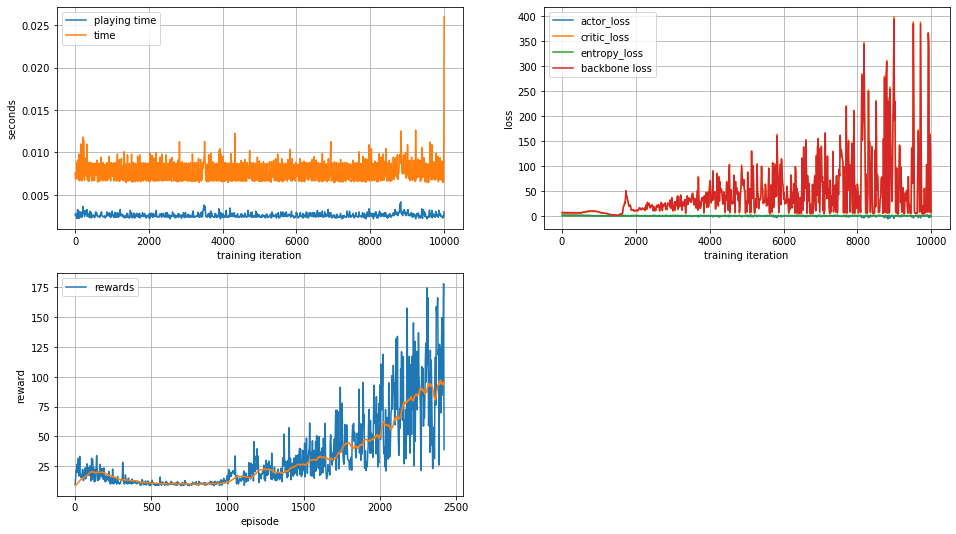

In [8]:
system.run(10000)

In [9]:
agent.runner.frames_done / sum(system.logger['time'])

1069.2055799028544

In [10]:
system.run(debug=True)

runner: plays one step.
  policy: received act query.
  backbone: forward pass for state computed
  policy: forward pass for state computed
trainer: initiates loss computation.
  runner: returns same transitions
  actor_loss: no batch is found, loss is None.
trainer: loss is None; no optimization step is performed.


# QAC

Actor-Critic where critic is trained via Q-learning. Yep.

In [11]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy", threads=8),
    rollout         = RolloutCollector(runner="runner", rollout_length=5),
    actor_backbone  = Backbone(CartpoleNN()),
    policy          = PolicyHead(backbone="actor_backbone"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = Sampler(replay="replay"),
    q_backbone      = Backbone(CartpoleNN()),
    q_head          = QualityHead(backbone="q_backbone"),
    q_loss          = OptimalCriticLoss(sampler="sampler", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="q_backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    q_trainer       = Trainer(backbone="q_backbone", losses=["q_loss"]),
    actor_loss      = ActorLoss(rollout="rollout", policy="policy", advantage_provider="q_head"),
    entropy_loss    = EntropyLoss(rollout="rollout", policy="policy"),
    trainer         = Trainer(backbone="actor_backbone", losses=["actor_loss", "entropy_loss"], weights=[1, 0.01])
)

In [12]:
system = System(agent, make_env=make_env)

Adding new head <policy> to <actor_backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])
Adding new head <q_head> to <q_backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


In [13]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in parallel environments each 1 iteration using <policy>
<rollout>: Collects rollouts of length 5 from <runner>
<actor_backbone>: Backbone of network
<policy>: Head, connected to <actor_backbone>, modeling Policy
<replay>: Stores observations from <runner>
<sampler>: Samples mini-batches from <replay>
<q_backbone>: Backbone of network
<q_head>: Head, connected to <q_backbone>, modeling Quality
<q_loss>: Calculates one-step optimal TD loss for <q_head> using <frozen_head> as target calculator and data from <sampler>
<frozen_backbone>: Copy of <q_backbone>, updated each 100 iteration
<frozen_head>: Copy of <q_head>, updated each 100 iteration
<q_trainer>: Trains <q_backbone> with all heads using following losses: <q_loss>
<actor_loss>: Calculates gradient estimation for <policy> using advantages from <q_head> and rollouts from <rollout>
<entropy_loss>: Calculates entropy penalty for <policy> using rollouts from <rollou

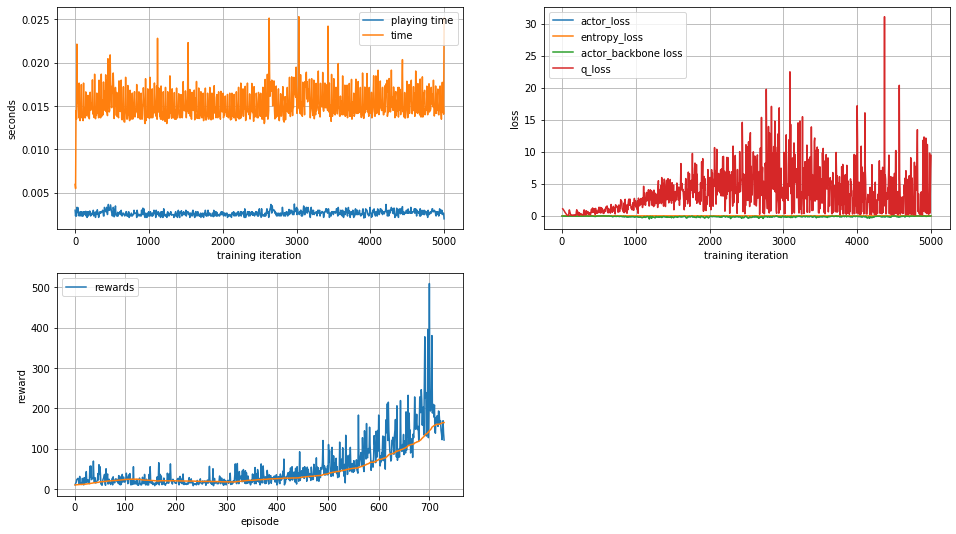

In [14]:
system.run(5000)